<a href="https://colab.research.google.com/github/kyle-gao/ML_ipynb/blob/master/TF_CatLSGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#An implementation of LSGAN https://arxiv.org/abs/1611.04076
trained on the cat face dataset https://www.kaggle.com/spandan2/cats-faces-64x64-for-generative-models

-We use a similar achitecture as in the paper, the same value function and and similar hyperparameters. 


In [62]:
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
import shutil
#shutil.unpack_archive("cat_face.zip", "Train")
shutil.unpack_archive("gif.zip", "Gif")

In [3]:
import tensorflow as tf
import glob
import imageio
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [4]:
 print(tf.__version__)

2.3.0


In [5]:
data_dir = "Train/cats"

In [6]:
batch_size = 512
size = 64
noise_dim = 128

In [ ]:
train = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0,
  batch_size=batch_size)

Found 15747 files belonging to 1 classes.


In [ ]:
preprocesslayers = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(size, size),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
def preprocess(ds):
  ds=ds.map(lambda data,y: preprocesslayers(data),num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds=ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

In [ ]:
ds_train = preprocess(train)

In [ ]:
meow=next(iter(ds_train))[0]

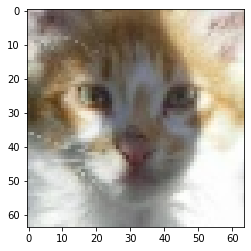

In [ ]:
plt.imshow(meow)

In [7]:
def make_generator():
  alpha = 0.2
  model= tf.keras.Sequential([
                              layers.Dense(4*4*256, use_bias=False, input_shape=(noise_dim,)),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(alpha),
                              layers.Reshape((4,4,256)),

                              layers.Conv2DTranspose(256,(3,3),strides=(2,2),padding="same",use_bias=False),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(alpha),
                              #(8,8,256)

                              layers.Conv2DTranspose(256,(3,3),strides=(1,1),padding="same",use_bias=False),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(alpha),
                              #(16,16,128)

                              layers.Conv2DTranspose(256,(3,3),strides=(2,2),padding="same",use_bias=False),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(alpha),
                              #(32,32,64)

                              layers.Conv2DTranspose(256,(3,3),strides=(1,1),padding="same",use_bias=False),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(alpha),
                              #(64,64,32)

                              layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding="same",use_bias=False),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(alpha),
                              #(64,64,32)

                              layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding="same",use_bias=False),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(alpha),
                              #(64,64,32)


                              layers.Conv2DTranspose(3,(3,3), strides=(1,1),padding="same",use_bias=False,activation='tanh')

  ])
  
  return model

In [8]:
generator=make_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              524288    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         589824    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0

In [9]:
def make_discriminator():
  alpha = 0.2
  model=tf.keras.Sequential([layers.GaussianNoise(0.1,input_shape=(64,64,3)),
                             layers.Conv2D(32,(5,5),strides=(2,2),padding='same',input_shape=(64,64,3)),
                             layers.LeakyReLU(alpha),
                             layers.Dropout(0.2),

                             layers.Conv2D(64,(5,5),strides=(2,2),padding='same'),
                             layers.BatchNormalization(),
                             layers.LeakyReLU(alpha),
                             layers.Dropout(0.2),

                             layers.Conv2D(128,(5,5),strides=(2,2),padding='same'),
                             layers.BatchNormalization(),
                             layers.LeakyReLU(alpha),
                             layers.Dropout(0.2),

                             layers.Conv2D(256,(5,5),strides=(2,2),padding='same'),
                             layers.BatchNormalization(),
                             layers.LeakyReLU(alpha),
                             layers.Dropout(0.2),

                             layers.Flatten(),
                             layers.Dense(1,activation="sigmoid")]) #We use from_logits=True
  return model

In [10]:
discriminator = make_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 64)       

In [11]:
noise = tf.random.normal([1,noise_dim])
generatedimage=generator(noise,training=False)
decision = discriminator(generatedimage)
print(decision)

tf.Tensor([[0.5000151]], shape=(1, 1), dtype=float32)


#Loss and optimizers

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
MSE =tf.keras.losses.MeanSquaredError() #For LSGAN

In [13]:
def discriminator_loss(real,fake):
  #takes a tuple of batch of discriminator outputs
  real_loss = MSE(tf.ones_like(real),real) #optimum when predicting all reals to be 1.
  fake_loss = MSE(tf.zeros_like(fake),fake) #optimum when predicting all fakes to be 0.
  return 0.5*real_loss + 0.5*fake_loss

def generator_loss(fake):
  #takes a batch of discriminator outputs
  return MSE(tf.ones_like(fake),fake) #using 0.5 as update as sugested by Hejlm et al. (2017) 

lr = 0.0003
beta1=0.5
generator_optimizer = tf.keras.optimizers.Adam(lr,beta_1=beta1)
discriminator_optimizer = tf.keras.optimizers.Adam(lr,beta_1=beta1)
#generator_optimizer = tf.keras.optimizers.SGD()
#generator_optimizer = tf.keras.optimizers.SGD()

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 200
num_examples_to_generate = 16

In [ ]:
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Training loop

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    gen_loss=0
    disc_loss=0


    for image_batch in dataset:
      gen_loss_step,disc_loss_step=train_step(image_batch)
      gen_loss += gen_loss_step
      disc_loss+= disc_loss_step
    gen_loss = gen_loss/11776
    disc_loss = disc_loss/11776
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1 + 100, time.time()-start))
    print (f'Generator loss: {gen_loss} Discriminator loss {disc_loss}')

    gen_losses.append(gen_loss)
    disc_losses.append(disc_loss)
    plt.plot(gen_losses)
    plt.plot(disc_losses)

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs + 100,
                           seed)
  return gen_losses,disc_losses

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  return predictions

In [ ]:
gen_losses=[]
disc_losses=[]
gen_losses,disc_losses= train(ds_train, EPOCHS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


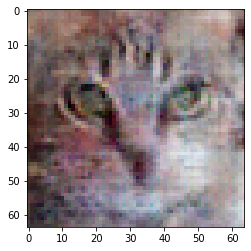

In [74]:
noise = tf.random.normal([16,noise_dim])
generatedimage=generator(noise,training=False)
plt.imshow(generatedimage[0,:,:,:])

In [76]:
images=tf.cast(generatedimage*255,tf.int16)
images = images*(images.numpy()>=0) #filter out negative pixel values (set to 0)

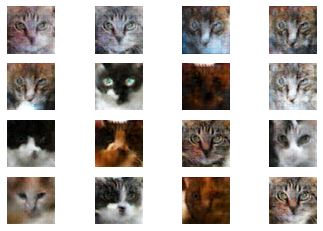

In [77]:
  for i in range(images.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(images[i, :, :, :])
      plt.axis('off')

In [19]:
generator.load_weights("./Generator/Generator_Save")

In [20]:
discriminator.load_weights("./Discriminator/Discriminator_Save")

In [30]:
def display_image(epoch_no):
  return PIL.Image.open('./Gif/gif/image_at_epoch_{:04d}.png'.format(epoch_no))

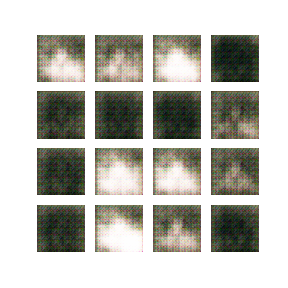

In [31]:
display_image(5)

In [65]:
anim_file = 'lscatgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./Gif/gif/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


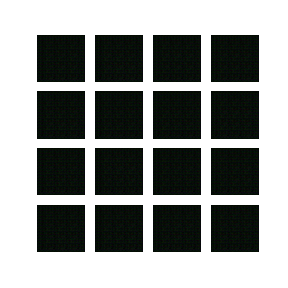

In [66]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

It seems we have trained a few epochs too many and reached some degree of mode collapse. We see around half the cats in the final outputs bearing the same facial expression. 